## Dự đoán giá chứng khoán bằng thuật toán LSTM và Linear Regression

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import metrics
from sklearn import preprocessing;
from sklearn.model_selection import train_test_split
from sklearn import linear_model;
from datetime import datetime
import investpy
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

<h4><center>Crawl data chứng khoán của 3 mã VIC, FPT, GAS, VCB bằng thư viện investpy và lưu vào 3 DataFrame</center></h4>

In [ ]:
VIC = investpy.get_stock_historical_data(stock='VIC',
                                        country='VietNam',
                                        from_date='01/01/2020',
                                        to_date='10/06/2022')

FPT =  investpy.get_stock_historical_data(stock='FPT',
                                        country='VietNam',
                                        from_date='01/01/2020',
                                        to_date='10/06/2022')

GAS =  investpy.get_stock_historical_data(stock='GAS',
                                        country='VietNam',
                                        from_date='01/01/2020',
                                        to_date='10/06/2022')

VCB =  investpy.get_stock_historical_data(stock='VCB',
                                        country='VietNam',
                                        from_date='01/01/2020',
                                        to_date='10/06/2022')


<h4><center>Xuất các thông tin cơ bản</center></h4>

In [ ]:

VIC.info()
FPT.info()
GAS.info()
VCB.info()

In [ ]:
print(FPT.columns)

<h4><center>Xuất 10 dòng cuối</center></h4>

In [ ]:
company_list = [FPT, VIC, GAS, VCB]
company_name = ["FPT", "Vingroup", "PetroVietnam", "Vietcombank"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.tail(10)

<h4><center>Tổng quan về mã FPT (các giá trị như tổng số dòng, mean, std)</center></h4>

In [ ]:
FPT.describe()

<h4><center>Đồ thị giá đóng sàn của FPT</center></h4>

In [ ]:
plt.figure(figsize=(20, 8))
# plt.subplots_adjust(top=1.25, bottom=1.2)
FPT['Close'].plot()
plt.ylabel('Close')
plt.xlabel(None)
plt.title(f"Giá đóng cửa của mã FPT")

<h4><center>Đồ thị giá trần, giá sàn, giá đóng cửa và mở cửa</center></h4>

In [ ]:
from matplotlib.pyplot import title


plt.figure(figsize=(20, 8))
# plt.subplots_adjust(top=1.25, bottom=1.2)
FPT['Close'].plot()
FPT['Open'].plot()
FPT['High'].plot()
FPT['Low'].plot()
plt.xlabel(None)
plt.title(f"Giá đóng, mở, trần và sàn của FPT")

<h4><center>Tổng giao dịch của FPT trong 1 ngày (đơn vị tính VND)</center></h4>

In [ ]:
plt.figure(figsize=(20, 8))
# plt.subplots_adjust(top=1.25, bottom=1.2)
FPT['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Tổng giá trị giao dịch của mã FPT")

Đường MA (hay còn gọi là Moving Average) là đường trung bình động, thể hiện biến động, chỉ báo xu hướng của giá cổ phiếu trong một khoảng thời gian, được tính theo công thức lấy trung bình cộng của n ngày trong chu kỳ. Ví dụ MA(10) thì lấy trung bình cộng của 10 ngày đó. 

Đường MA thường lấy các mốc phổ biến như 10, 20 ngày đối với MA ngắn hạn, 50 ngày cho trung hạn và 100 hoặc 200 ngày đối với dài hạn 

In [ ]:
ma_day = [10, 20, 30, 50]
for ma in ma_day:
    column_name = f"MA for {ma} days"
    VIC[column_name] = VIC['Close'].rolling(ma).mean()
VIC.info()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)

VIC[['Close', 'MA for 10 days']].plot(ax=axes[0,0])
axes[0,0].set_title('MA(10) of Vingroup')

VIC[['Close', 'MA for 20 days']].plot(ax=axes[0,1])
axes[0,1].set_title('MA(20) of Vingroup')

VIC[['Close', 'MA for 30 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MA(30) of Vingroup')

VIC[['Close', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('MA(50) of Vingroup')

fig.tight_layout()

Daily Return là biểu đồ thể hiện sự chênh lệch của ngày hôm nay so với ngày trước đó. Nếu biên của ngày hôm đó nằm dưới mức 0 thì giá đóng phiên ngày đó thấp hơn ngày hôm trước và ngược lại

In [ ]:
FPT['Daily Return'] = FPT['Close'].pct_change()
VCB['Daily Return'] = VCB['Close'].pct_change()
GAS['Daily Return'] = GAS['Close'].pct_change()
VIC['Daily Return'] = VIC['Close'].pct_change()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(20)

FPT[['Daily Return']].plot(legend=True, linestyle='--', marker='o', ax=axes[0,0])
axes[0,0].set_title('FPT')

VIC[['Daily Return']].plot(legend=True, linestyle='--', marker='o',ax=axes[0,1])
axes[0,1].set_title('Vingroup')

GAS[['Daily Return']].plot(legend=True, linestyle='--', marker='o',ax=axes[1,0])
axes[1,0].set_title('Petrolimex')

VCB[['Daily Return']].plot(legend=True, linestyle='--', marker='o',ax=axes[1,1])
axes[1,1].set_title('Vietcombank')

fig.tight_layout()

<h4><center>Độ rủi ro khi đầu tư vào 4 mã chứng khoán</center></h4>

In [ ]:
closing_fpt = FPT['Close']
closing_VIC = VIC['Close']
closing_GAS = GAS['Close']
closing_VCB = VCB['Close']

closing_df = pd.concat([closing_fpt, closing_VIC, closing_GAS, closing_VCB], axis=1, keys=['FPT', 'VIC', 'GAS', 'VCB'])
stock_rets = closing_df.pct_change()
rets = stock_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(13, 10))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')
for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

<h2><center>Dự đoán bằng phương pháp Linear Regression</center></h2>

Hàm chia data train và test

In [ ]:
def split_data(X,Y):
    return X[:-40], Y[:-40], X[-40:], Y[-40:]

Hàm chuẩn hoá data về khoảng 0 1 và reshape để phù hợp với chuẩn hoá dữ liệu

In [ ]:
def data_for_linear(df, timesteps= 40):
    x=FPT.Close.values
    x=x.reshape(-1,1)
    #Normalization
    
    scaler = MinMaxScaler()
    x_noml=scaler.fit_transform(x)
    X=[]; Y=[]
    for i in range(x.shape[0]- timesteps):
        X.append(x_noml[i:i+timesteps])
        Y.append(x_noml[i+timesteps])
    X=np.array(X); Y= np.array(Y)
    X= np.reshape(X, (-1,timesteps))
    print('Input shape:{}, Output shape:{}'.format(X.shape, Y.shape))
    return X,Y, scaler

<h4><center>Chia tập data train test</center></h4>

In [ ]:
x_linear, ylinear, lin_scaler= data_for_linear(FPT)
xtrain, ytrain, xtest, ytest= split_data(x_linear, ylinear)

<h4><center>Tạo model với các siêu tham số (Hyper Parameter)</center></h4>

In [ ]:


liner_model= Sequential()
liner_model.add(Dense(128, activation=None, input_shape=(40,)))
liner_model.add(Dense(228, activation=None))
liner_model.add(Dense(64, activation=None))
liner_model.add(Dense(1, activation=None))

liner_model.compile(optimizer='adam', loss='mse')
liner_model.summary()

In [ ]:
his= liner_model.fit(xtrain, ytrain, epochs=40)

Forcasting

In [ ]:
#-------------- True Forecasting/predicting future sales--------------------#
ypred=[]
for i in range(xtest.shape[0]-1):
    p= liner_model.predict(xtest[i].reshape(1,40))
    ypred.append(p)
    xtest[i+1, -1]= p
ypred.append(liner_model.predict(xtest[i+1].reshape(1,40)))
#-------------- Note it!------------------------------------------------------#

In [ ]:

f, ax= plt.subplots(1, 2, figsize=(30,8))
ax[0].plot(lin_scaler.inverse_transform(ytrain))
ax[0].plot(lin_scaler.inverse_transform(liner_model.predict(xtrain)))
ax[0].set_title('Traning set, mse:{}'.format(mean_absolute_error(ytrain, liner_model.predict(xtrain))*100))
ax[0].set_ylabel('Open-stock-price')
ax[0].set_xlabel('Time')

ax[1].plot(lin_scaler.inverse_transform(ytest))
ax[1].plot(lin_scaler.inverse_transform(np.array(ypred).reshape(-1,1)))
ax[1].set_title('Testing-set, mse:{}'.format(mean_absolute_error(ytest, np.array(ypred).reshape(-1,1))*100))
ax[1].set_ylabel('Open-stock-price')
ax[1].set_xlabel('Time')
plt.show()

<h2><center>Dự đoán bằng phương pháp LSTM</center></h2>

In [278]:
from pandas_datareader.data import DataReader
scaler = MinMaxScaler(feature_range=(0,1))


dataset=FPT.Close.values
dataset=dataset.reshape(-1,1)
#Normalization

scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(dataset)

In [279]:
training_data_len = int(np.ceil( len(dataset) * .95 ))
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.14819769, 0.1400543 , 0.13516881, 0.14412599, 0.13353986,
       0.1400543 , 0.13924051, 0.1359826 , 0.13516881, 0.13516881,
       0.1433122 , 0.1400543 , 0.13842671, 0.12295509, 0.13109711,
       0.11644065, 0.09445596, 0.09038426, 0.092827  , 0.09445596,
       0.10748347, 0.10504072, 0.09934144, 0.10748347, 0.11155516,
       0.11318412, 0.1148117 , 0.11236896, 0.12702679, 0.12458404,
       0.12539783, 0.11644065, 0.09852628, 0.11074137, 0.1188834 ,
       0.12702679, 0.11969719, 0.12458404, 0.12621163, 0.12295509,
       0.11562686, 0.11074137, 0.08061328, 0.09201321, 0.08468361,
       0.06269892, 0.0631065 , 0.05862722, 0.06595545, 0.06514166,
       0.05944238, 0.05944238, 0.03257083, 0.03338462, 0.04559971,
       0.03094188, 0.02198606, 0.        , 0.00570065, 0.01547162])]
[0.03419978253287653]

[array([0.14819769, 0.1400543 , 0.13516881, 0.14412599, 0.13353986,
       0.1400543 , 0.13924051, 0.1359826 , 0.13516881, 0.13516881,
       0.1433122 , 0.1400543 , 0.13

In [280]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model_lstm.add(LSTM(64, return_sequences=False))
model_lstm.add(Dense(25))
model_lstm.add(Dense(1))

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_lstm.fit(x_train, y_train, batch_size=1, epochs=1)

518/518 [==============================] - 22s 34ms/step - loss: 0.0044


In [281]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model_lstm.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

1/1 [==============================] - 2s 2s/step


5780.704507644327

C:\Users\Kreazy\AppData\Local\Temp\ipykernel_9564\2082022913.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


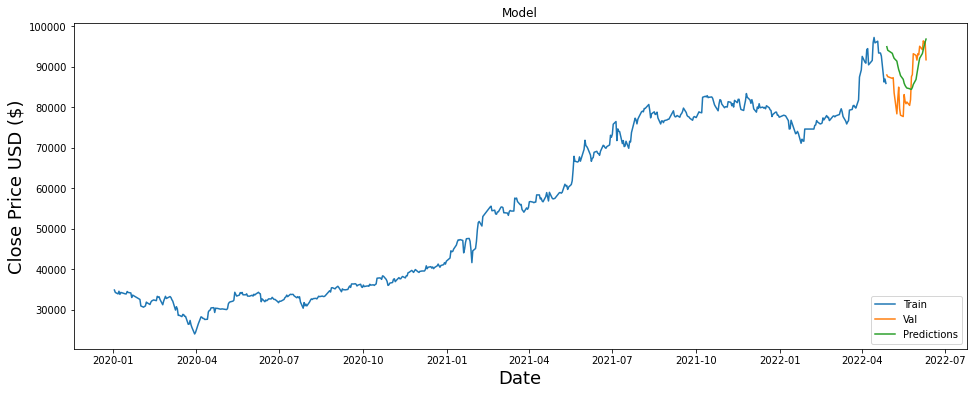

In [283]:
# Plot the data
train = FPT[:training_data_len]
valid = FPT[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()